In [3]:
import numpy as np
import scipy

# Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter

# Packages for saving files with timestamps
from datetime import datetime
import os

# Own functions
from independence_models import *
from MLE_estimator_tellurium import *
from MLE_estimator_IPS import *

In [4]:
# Create a time-stamped folder for the experiment
os.chdir('/home/user')
current_time = datetime.now()
timestamp_str = current_time.strftime('%Y%m%d_%H%M%S')
os.makedirs(timestamp_str, exist_ok=True)
os.chdir(timestamp_str)
print(os.getcwd())

/home/user/20241118_095206


In [5]:
# Fix the random number generator seed for reproducibility
np.random.seed(1234)

In [6]:
# Error tolerance for IPS
err_tol = 1e-8

## Helper functions

In [7]:
# Reorders the columns of the input matrix Lambda to ensure that the first rank many columns are linearly independent
def reorder_to_full_rank_block_first(Lambda):
    Q, R, pivot_columns = scipy.linalg.qr(Lambda,
                                          mode='economic',
                                          pivoting=True)
    return Lambda[:, pivot_columns]

In [8]:
# Start a new plot
def new_plot(figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 14})

In [9]:
#Create a plot of the real part of the eigenvalues
def eigenvalue_plot(E,
                    scale='log',
                    linestyle='-',
                    marker='.',
                    linewidth=2,
                    **kwargs):
    # Manually make a log-plot for negative values
    if scale == 'log' and all(x < 0 for x in E):
        plt.plot(-1 / E,
                 marker=marker,
                 linestyle=linestyle,
                 linewidth=linewidth,
                 **kwargs)
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(
            FuncFormatter(lambda tick_val, pos: f'-{tick_val:.1e}'))
    else:
        plt.plot(E,
                 marker=marker,
                 linestyle=linestyle,
                 linewidth=linewidth,
                 **kwargs)
        plt.yscale(scale)

    plt.xlabel(r'Index of eigenvalue $\lambda$')
    plt.ylabel('Re($\lambda$)')

In [10]:
# Create a plot of the maximal time-scales
def max_eigenvalue_plot(cardinalities,
                        E,
                        scale='log',
                        linestyle='-',
                        marker='.',
                        linewidth=2,
                        **kwargs):
    # Manually make a log-plot for negative values
    if scale == 'log' and all(x < 0 for x in E):
        plt.plot(cardinalities,
                 -1 / E,
                 marker=marker,
                 linestyle=linestyle,
                 linewidth=linewidth,
                 **kwargs)
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(
            FuncFormatter(lambda tick_val, pos: f'-{tick_val:.1e}'))
    else:
        plt.plot(cardinalities,
                 E,
                 marker=marker,
                 linestyle=linestyle,
                 linewidth=linewidth,
                 **kwargs)
        plt.yscale(scale)
        
    plt.xlabel(r'$|\Lambda|$')
    plt.ylabel('Re($\lambda_\mathrm{max}$)')

## Independence model

In [11]:
a = 10
b = 10

# Design matrix
A = independence_model(a, b)

# Random choice of observed distribution
u = np.random.randint(10, 50, size=(1, A.shape[1]))
u = u / sum(u)

# Estimation of MLE with IPS
MLE = IPS(A, u, err_tol=err_tol)

In [12]:
# Save the information about the model

model_str = f'independence_model_{a}_{b}'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [13]:
# Markov basis (sorted so that the first columns form a full-rank matrix)
Lambda_mb = reorder_to_full_rank_block_first(
    independence_model_markov_basis(a, b))

In [14]:
# Pick cardinalities for the spanning sets
number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0


1


2


3


4


5


6


7


8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


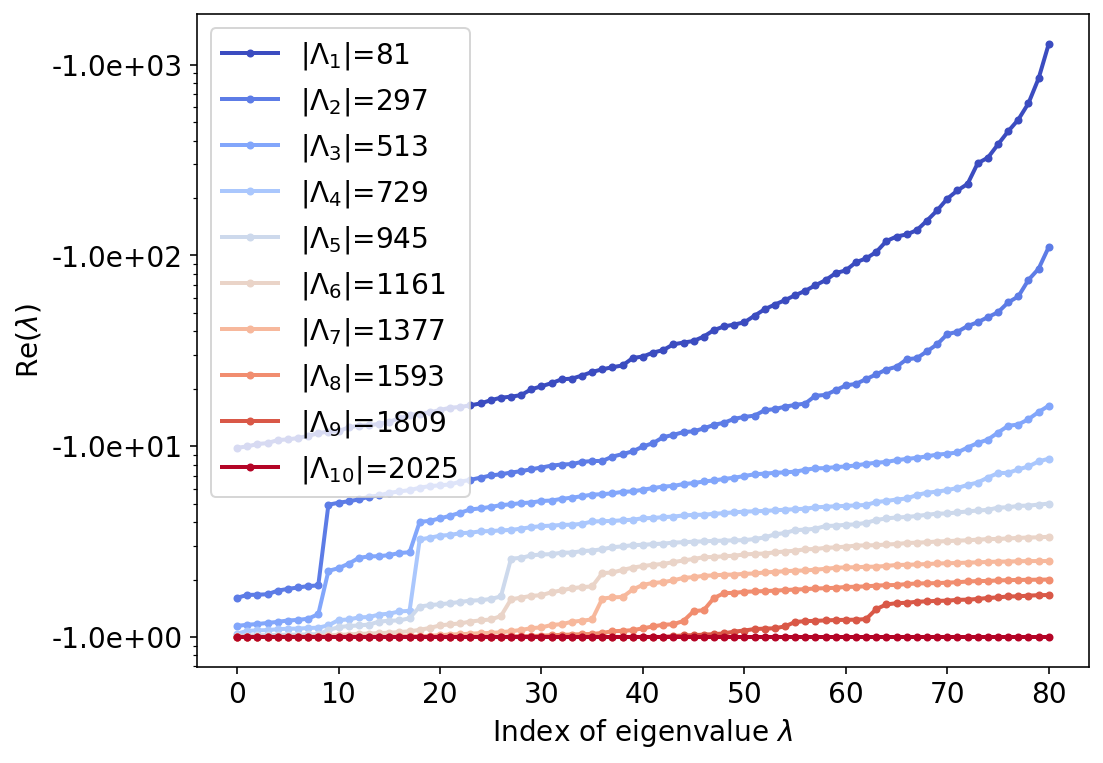

In [15]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a Markov basis

dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

E_independence_mb = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_independence_mb[i, :] = real_part_of_eigenvalues(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_independence_mb[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_independence_mb[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    color=colors[i])

plt.legend()
plt.savefig(dir_name + f'/independence_model_increasing_lambda.eps',
            format='eps', bbox_inches='tight')
plt.savefig(dir_name + f'/independence_model_increasing_lambda.pdf',
            format='pdf', bbox_inches='tight')
plt.show()

0


1


2


3


4


5


6


7


8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


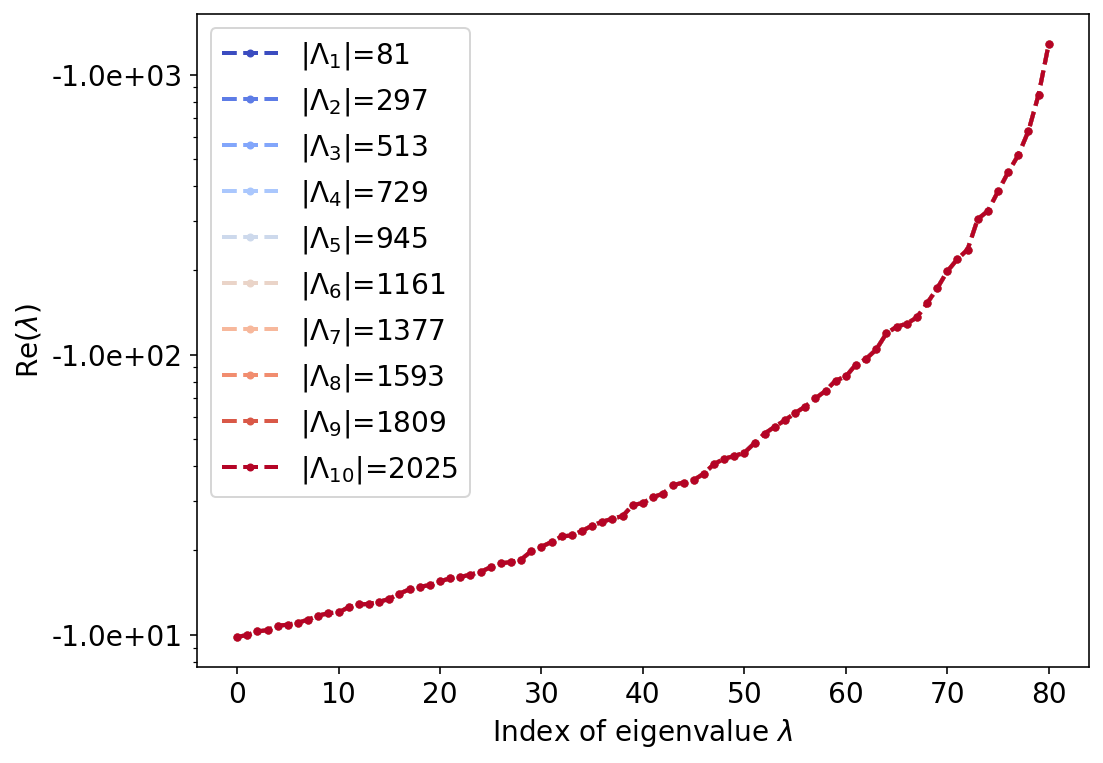

In [16]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a random spanning set

dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1, 0, 1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)],
                             extension_matrix)

E_independence_random = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

new_plot()

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_independence_random[i, :] = real_part_of_eigenvalues(
        Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_independence_random[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_independence_random[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    linestyle='--',
                    color=colors[i])

plt.legend()

plt.savefig(dir_name +
            f'/independence_model_increasing_lambda_to_random_spanning.eps',
            format='eps', bbox_inches='tight')
plt.savefig(dir_name +
            f'/independence_model_increasing_lambda_to_random_spanning.pdf',
            format='pdf', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


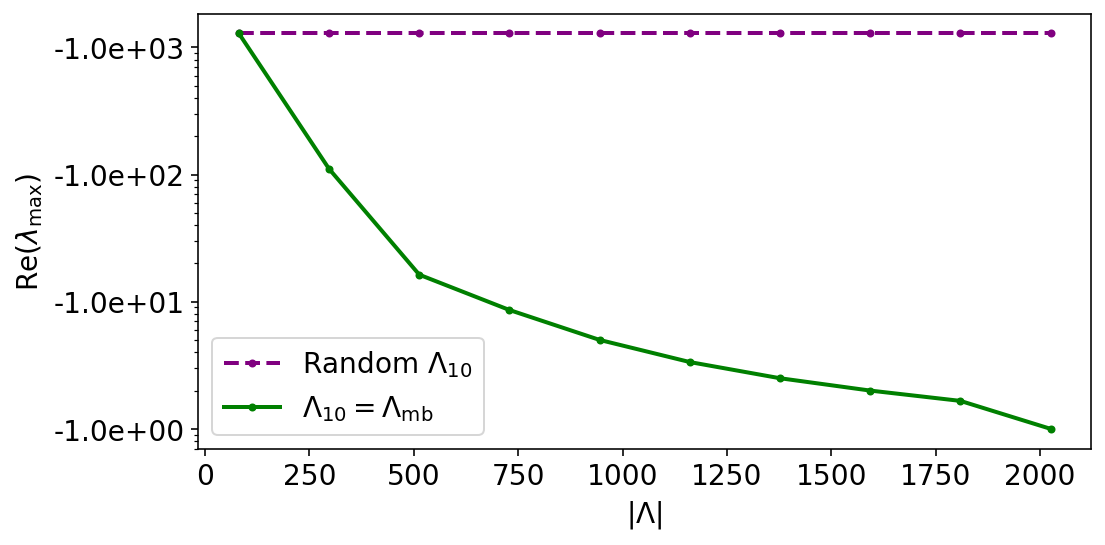

In [17]:
# Comparison of how the least negative eigenvalue varies when Lambda grows towards a Markov basis and a random spanning set, respectively

new_plot(figsize=(8, 4))
max_eigenvalue_plot(cardinalities,
                    E_independence_random[:, -1],
                    label=f'Random $\Lambda_{{{number_of_cardinalities}}}$',
                    linestyle='--',
                    color='purple')
max_eigenvalue_plot(cardinalities,
                    E_independence_mb[:, -1],
                    label=f'$\Lambda_{{{number_of_cardinalities}}}=\Lambda_\mathrm{{mb}}$',
                    color='green')

plt.legend()

plt.savefig(f'independence_model_max_eigenvalues.eps', format='eps', bbox_inches='tight')
plt.savefig(f'independence_model_max_eigenvalues.pdf', format='pdf', bbox_inches='tight')

## 4-cycle

In [18]:
A = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
              [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
              [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])

Lambda_mb = np.array([[0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1],
                      [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1, 0],
                      [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
                      [0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
                      [-1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
                      [0, -1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                      [-1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [1, -1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, -1],
                      [1, -1, 0, 0, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 1, -1],
                      [1, 0, -1, 0, 0, -1, 0, 1, -1, 0, 1, 0, 0, 1, 0, -1],
                      [0, 1, -1, 0, 0, -1, 1, 0, 0, -1, 1, 0, 0, 1, -1, 0],
                      [1, 0, 0, -1, -1, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0, -1],
                      [0, 1, 0, -1, -1, 0, 1, 0, 0, -1, 0, 1, 1, 0, -1, 0],
                      [0, 0, 1, -1, 0, 0, -1, 1, -1, 1, 0, 0, 1, -1, 0, 0],
                      [0, 0, 0, 0, 1, -1, -1, 1, -1, 1, 1, -1, 0, 0, 0,
                       0]]).transpose()

Lambda_mb = reorder_to_full_rank_block_first(Lambda_mb)

u = np.random.randint(10, 50, size=(1, Lambda_mb.shape[0]))
u = u / sum(u)

MLE = IPS(A, u, err_tol=err_tol)

In [19]:
model_str = f'4_cycle'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [20]:
# Pick cardinalities for the spanning sets
number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0
1


2
3
4


5
6


7
8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


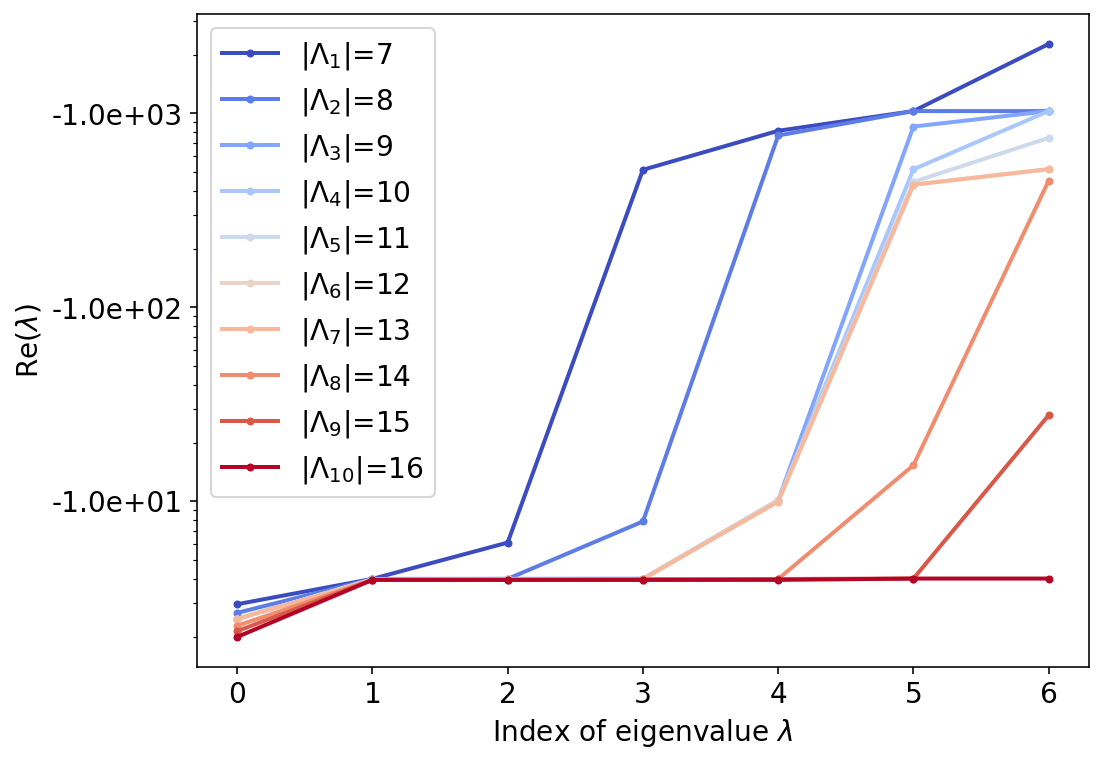

In [21]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a Markov basis

dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

E_cycle_mb = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_cycle_mb[i, :] = real_part_of_eigenvalues(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_cycle_mb[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_cycle_mb[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    color=colors[i])

plt.legend()
plt.savefig(dir_name + '/4-cycle_model_increasing_lambda.eps', format='eps', bbox_inches='tight')
plt.savefig(dir_name + '/4-cycle_model_increasing_lambda.pdf', format='pdf', bbox_inches='tight')

plt.show()

0
1


2
3


4
5


6
7


8
9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


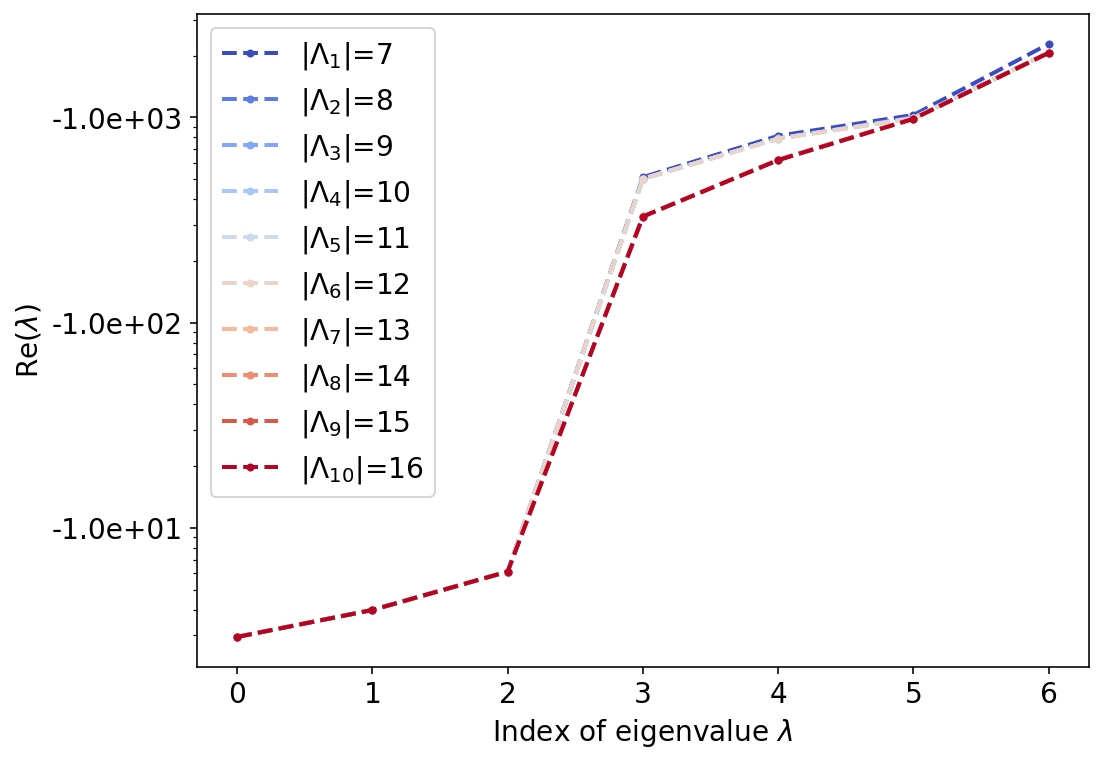

In [22]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a random spanning set

dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1, 0, 1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)],
                             extension_matrix)

new_plot()

E_cycle_random = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_cycle_random[i, :] = real_part_of_eigenvalues(
        Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_cycle_random[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_cycle_random[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    linestyle='--',
                    color=colors[i])

plt.legend()

plt.savefig(dir_name + '/4-cycle_increaasing_lambda_to_random_spanning.eps',
            format='eps', bbox_inches='tight')
plt.savefig(dir_name + '/4-cycle_increasing_lambda_to_random_spanning.pdf',
            format='pdf', bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


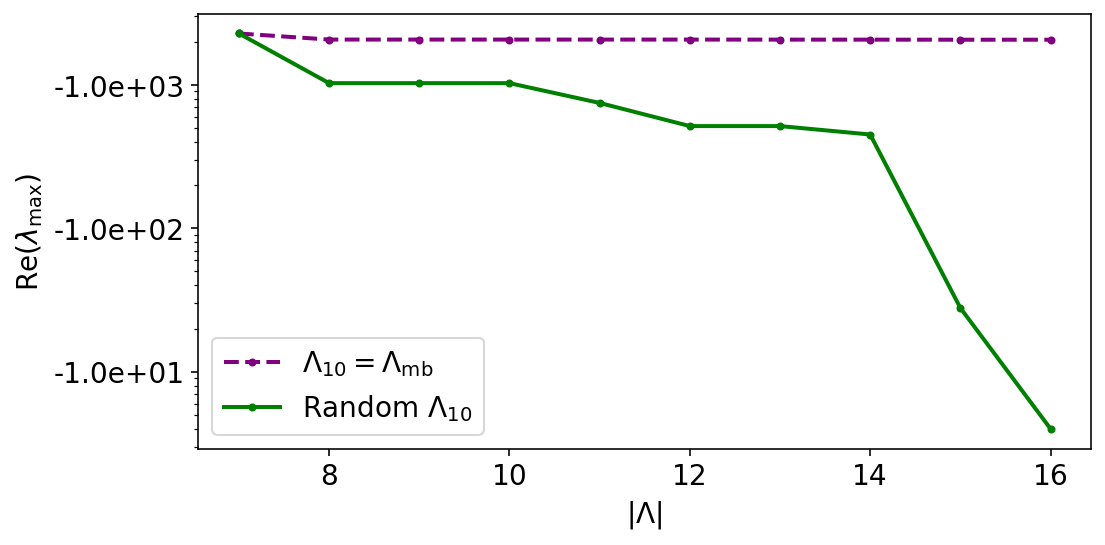

In [23]:
# Comparison of how the least negative eigenvalue varies when Lambda grows towards a Markov basis and a random spanning set, respectively

new_plot(figsize=(8, 4))
max_eigenvalue_plot(cardinalities,
                    E_cycle_random[:, -1],
                    label=f'$\Lambda_{{{number_of_cardinalities}}}=\Lambda_\mathrm{{mb}}$',
                    color='purple',
                    linestyle='--')
max_eigenvalue_plot(cardinalities,
                    E_cycle_mb[:, -1],
                    label=f'Random $\Lambda_{{{number_of_cardinalities}}}$',
                    color='green')

plt.legend()

plt.savefig(f'4-cycle_max_eigenvalues.eps', format='eps', bbox_inches='tight')
plt.savefig(f'4-cycle_max_eigenvalues.pdf', format='pdf', bbox_inches='tight')

## Additional example: Randomly generated design matrix



In [24]:
A = np.array([[3, 1, 2, 1, 2, 1, 3, 1, 1], [0, 3, 0, 2, 3, 0, 0, 3, 2],
              [2, 3, 1, 0, 2, 0, 1, 3, 3], [2, 0, 4, 4, 0, 6, 3, 0, 1]])

Lambda_mb = np.array([[0, -1, 0, 1, 0, 1, 2, 0, 3, 0, 1, -1, -2],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 2, 0, 1, 0, 1, -1, 0, 0, 0, 1, -1, 1],
                      [0, 0, -1, 0, 1, 1, 1, -2, 1, 0, 0, -2, -2],
                      [0, 0, 0, 1, -2, -1, -1, 2, 0, -2, -1, 1, 1],
                      [0, -1, 1, 0, -1, -1, 0, 2, 0, 0, 0, 2, 1],
                      [0, 0, 0, -2, 1, -1, -1, -1, -3, 1, -1, 1, 1],
                      [-1, 0, 2, -1, 2, 1, 1, 0, 0, 4, 3, 1, 1],
                      [0, 0, -2, 0, -1, -1, -1, -1, -1, -3, -3, -1, -1]])

Lambda_mb = reorder_to_full_rank_block_first(Lambda_mb)

u = np.random.randint(10, 50, size=(1, Lambda_mb.shape[0]))
u = u / sum(u)

MLE = IPS(A, u, err_tol=err_tol)

In [25]:
model_str = f'random'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [26]:
# Pick cardinalities for the spanning sets

number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0
1
2


3
4
5


6
7
8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


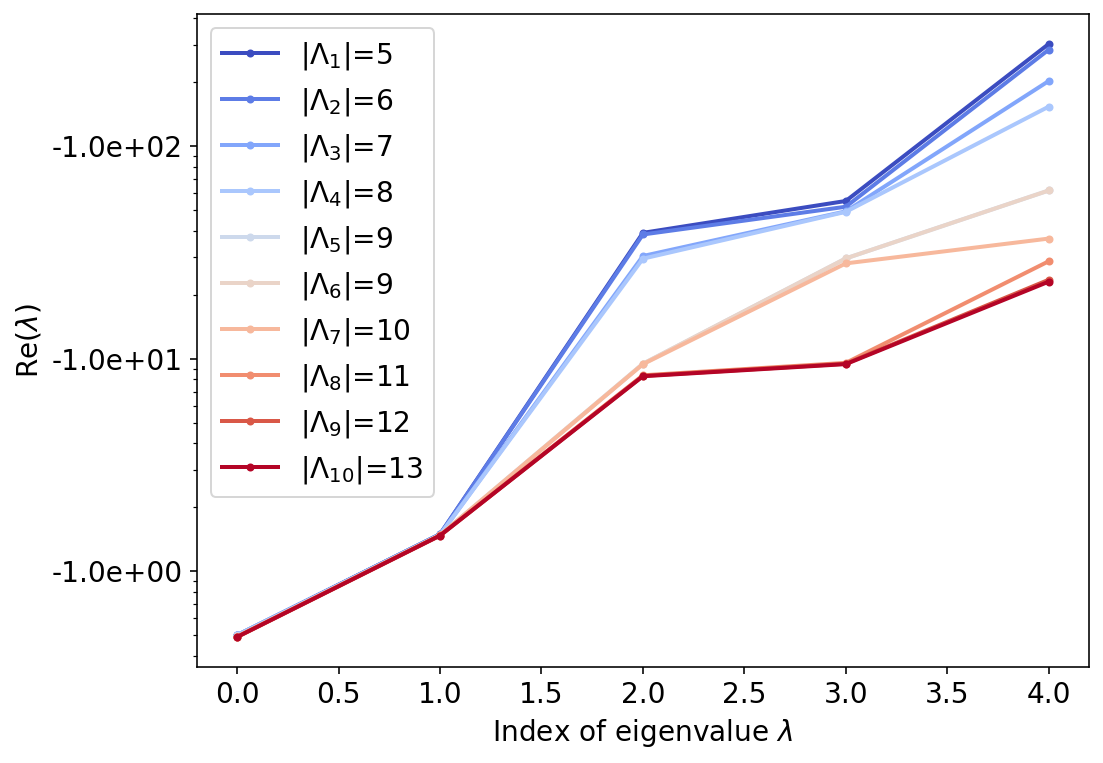

In [27]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a Markov basis

dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

E_random_mb = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_random_mb[i, :] = real_part_of_eigenvalues(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_random_mb[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_random_mb[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    color=colors[i])

plt.legend()
plt.savefig(dir_name + '/random_model_increasing_lambda.eps', format='eps', bbox_inches='tight')
plt.savefig(dir_name + '/random_model_increasing_lambda.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [28]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1, 0, 1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)],
                             extension_matrix)

0
1
2


3
4
5


6
7
8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


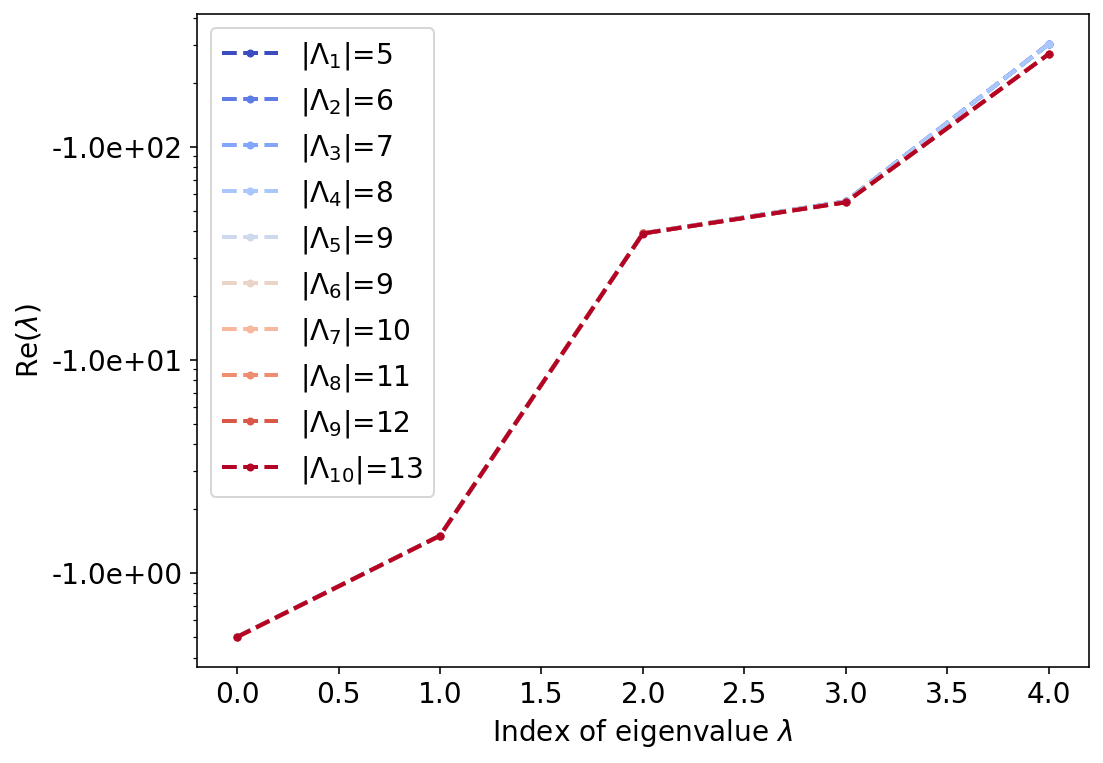

In [29]:
# Plot the distribution of the real parts of the eigenvalues when Lambda increases towards a random spanning set

new_plot()

E_random_random = np.zeros((np.size(cardinalities), te.rank(Lambda_mb)))

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    E_random_random[i, :] = real_part_of_eigenvalues(
        Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/eigenvalues_for_Lambda{i+1}.txt',
               E_random_random[i, :],
               delimiter=',',
               fmt='%.5f')
    eigenvalue_plot(E_random_random[i, :],
                    label=f'|Λ$_{{{i+1}}}$|={m}',
                    linestyle='--',
                    color=colors[i])

plt.legend()

plt.savefig(dir_name + '/random_increaasing_lambda_to_random_spanning.eps',
            format='eps', bbox_inches='tight')
plt.savefig(dir_name + '/random_increasing_lambda_to_random_spanning.pdf',
            format='pdf', bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


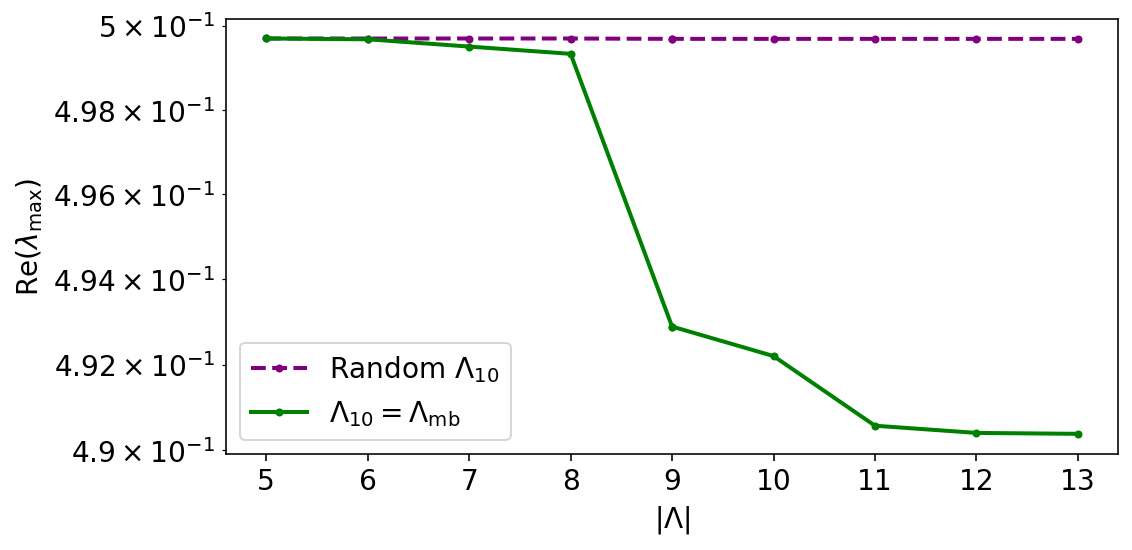

In [30]:
# Comparison of how the least negative eigenvalue varies when Lambda grows towards a Markov basis and a random spanning set, respectively

new_plot(figsize=(8,4))
max_eigenvalue_plot(cardinalities,
                    E_random_random[:, 0],
                    label=f'Random $\Lambda_{{{number_of_cardinalities}}}$',
                    color='purple',
                    linestyle='--')
max_eigenvalue_plot(cardinalities,
                    E_random_mb[:, 0],
                    label=f'$\Lambda_{{{number_of_cardinalities}}}=\Lambda_\mathrm{{mb}}$',
                    color='green')

plt.legend()

plt.savefig(f'random_random_max_eigenvalues.eps', format='eps', bbox_inches='tight')
plt.savefig(f'random_random_max_eigenvalues.pdf', format='pdf', bbox_inches='tight')